### This notebook shows identifying the duplicated data and calculating image stats of leftover set, and finally saving usable images into a new csv file
---
[1. Loading training images](#step1)

[2. Find duplicates via phash](#step2)

[3. Create the deduplicated csv file](#step3)

In [1]:
%load_ext autoreload
%autoreload 2

##### 1. Loading training images<a id='step1'/>

In [2]:
import sys

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../..")
from src.image import get_image_with_id, plot_rgb, plot_rgby
from src.data import DataPaths, open_numpy, label_to_string

In [3]:
image_paths = list(DataPaths.TRAIN_COMBINED_IMAGES.glob("*")) + list(DataPaths.TRAIN_COMBINED_IMAGES_HPAv18.glob("*"))
image_paths.sort(key=lambda x: x.stem)
df = pd.concat([pd.read_csv(DataPaths.TRAIN_LABELS), pd.read_csv(DataPaths.TRAIN_LABELS_HPAv18)])
df = df.sort_values(by=['Id'])
df['image_paths'] = image_paths

In [4]:
assert np.all(df['Id'].values ==  [p.stem for p in df['image_paths'].values])

##### 2. Find duplicates via phash<a id='step2'/>

In [5]:
import imagehash
from PIL import Image
from miniutils.progress_bar import parallel_progbar, progbar

In [14]:
def mapper(data):
    name, image_path = data
    image = open_numpy(image_path)
    phash = imagehash.phash(Image.fromarray(image.px))
    return (name, phash.hash.flatten())

In [15]:
names, image_paths = df['Id'], df['image_paths']
iterable = zip(names, image_paths)
names_and_phashes = parallel_progbar(mapper, iterable)

In [16]:
names, phashes = zip(*names_and_phashes)

In [17]:
phash_df_data = []
for i, (name, phash) in progbar(enumerate(zip(names, phashes))):
    similarities = (len(phash) - (phash ^ phashes).sum(axis=1))/len(phash)
    for similarity, name_of_image_compared in zip(similarities, names):
        if similarity > 0.75 and name != name_of_image_compared:
            phash_df_data.append({
                "original_name": name,
                "compared_image_name": name_of_image_compared,
                "similarity": similarity
            })

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
similarity_df = pd.DataFrame(phash_df_data)
similarity_df.to_csv("test.csv", index=False)

In [19]:
similarity_df = pd.read_csv("test.csv")
sorted_similarity_df = similarity_df.sort_values(['similarity'], ascending=[False])

In [20]:
sorted_similarity_df.head()

,compared_image_name,original_name,similarity
236387,a0bb7462-bb9f-11e8-b2b9-ac1f6b6435d0,56586_913_F7_4,1.0
113249,a32c13d4-bba7-11e8-b2ba-ac1f6b6435d0,34814_370_A9_2,1.0
337729,47130_1314_A6_2,b95f1756-bbc4-11e8-b2bc-ac1f6b6435d0,1.0
113311,e0e8830e-bb9f-11e8-b2b9-ac1f6b6435d0,34828_836_B4_2,1.0
350903,74086_1537_A12_2,da9b2838-bbb0-11e8-b2ba-ac1f6b6435d0,1.0


In [21]:
sorted_similarity_df['similarity'].value_counts()

0.78125    316704
0.81250     31362
0.96875      5312
0.93750      3566
0.84375      3328
1.00000      2238
0.90625      1926
0.87500      1418
Name: similarity, dtype: int64

In [31]:
get_samples_with_similarity = lambda df, similarity: df['similarity'].map(lambda x: x == similarity)
get_samples_with_similarity_above_and_equal = lambda df, similarity: df['similarity'].map(lambda x: x >= similarity)

In [ ]:
df_with_samples = sorted_similarity_df[get_samples_with_similarity(sorted_similarity_df, 0.875)]
for i, (name1, name2) in enumerate(zip(df_with_samples['original_name'].values.tolist(),
                                      df_with_samples['compared_image_name'].values.tolist())):
    plot_rgby(get_image_with_id(name1))
    plot_rgby(get_image_with_id(name2))
    plt.show()
    if i == 50:
        break

Get rid of all the images that have a similarity score of 0.93750 and above

In [32]:
filtered_similarity_df = sorted_similarity_df[get_samples_with_similarity_above(sorted_similarity_df, 0.93750)]

In [33]:
filtered_similarity_df.shape

(11116, 3)

In [36]:
filtered_names = filtered_similarity_df['original_name'].values if "-" not in name]

In [59]:
filtered_names = []
for i, (name1, name2) in enumerate(zip(filtered_similarity_df['original_name'].values.tolist(),
                                       filtered_similarity_df['compared_image_name'].values.tolist())):
    if "-" in name1 and "-" in name2:
        filtered_names.append(name1)
    elif "-" in name1:
        filtered_names.append(name1)
    elif "-" in name2:
        filtered_names.append(name2)
    else:
        filtered_names.append(name1)

In [61]:
unique_filtered_names = list(set(filtered_names))

In [63]:
len(unique_filtered_names)

5877

#### 3. Create the deduplicated csv file<a id='step3'/>

In [65]:
df = pd.concat([pd.read_csv(DataPaths.TRAIN_LABELS), pd.read_csv(DataPaths.TRAIN_LABELS_HPAv18)])

In [67]:
df_without_dupes = df[df['Id'].map(lambda x: x not in filtered_names)]

In [69]:
df_without_dupes.shape

(99801, 2)

In [73]:
df_without_dupes.to_csv(DataPaths.TRAIN_LABELS_ALL_NO_DUPES, index=False)

Just a helper function to load training data

In [149]:
from collections import Counter
from typing import List, Union, Tuple
from functools import reduce
from pathlib import Path
from operator import add

from src.data import make_one_hot

def load_training_data(root_image_paths: Union[List[str], List[List[str]]], root_label_paths: List[str],
                       use_n_samples: Union[None, int] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    labels_df = pd.read_csv(root_label_paths)
    labels_df['Target'] = [[int(i) for i in s.split()] for s in labels_df['Target']]
    image_id_with_labels = labels_df['Id']
    image_id_with_labels_lookup = Counter(image_id_with_labels)
    
    root_image_paths_is_nested_lists = isinstance(root_image_paths[0], list)
    merged_image_paths = reduce(add, root_image_paths if root_image_paths_is_nested_lists else [root_image_paths])
    merged_image_paths = [Path(p) for p in merged_image_paths]
    image_paths_used_for_training = [p for p in merged_image_paths if image_id_with_labels_lookup.get(p.stem) is not None]
    
    sorted_labels_df = labels_df.sort_values(["Id"], ascending=[True])
    sorted_image_paths_used_for_training = sorted(image_paths_used_for_training, key=lambda x: x.stem)
    assert np.all(np.array([p.stem for p in sorted_image_paths_used_for_training]) == sorted_labels_df["Id"])
    
    if use_n_samples is not None:
        sampled_idx = np.random.choice(len(sorted_image_paths_used_for_training), size=(use_n_samples)).flatten()
        sorted_image_paths_used_for_training= np.array(sorted_image_paths_used_for_training)[sampled_idx]
        labels_df = labels_df.iloc[sampled_idx]
        
    labels = labels_df['Target'].values
    labels_one_hot = make_one_hot(labels, n_classes=28)
    return np.array(sorted_image_paths_used_for_training), np.array(labels), np.array(labels_one_hot)

In [150]:
X, y, y_one_hot = load_training_data(
    root_image_paths=[[str(p) for p in DataPaths.TRAIN_COMBINED_IMAGES.glob("*")],
                      [str(p) for p in DataPaths.TRAIN_COMBINED_IMAGES_HPAv18.glob("*")]],
    root_label_paths=str(DataPaths.TRAIN_LABELS_ALL_NO_DUPES)
)

In [151]:
X, y, y_one_hot = load_training_data(
    root_image_paths=[str(p) for p in DataPaths.TRAIN_COMBINED_IMAGES.glob("*")],
    root_label_paths=str(DataPaths.TRAIN_LABELS)
)

In [141]:
X[0]

PosixPath('../../data/train_combined/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0.npy')

In [142]:
y[0]

[16, 0]

In [143]:
y_one_hot[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

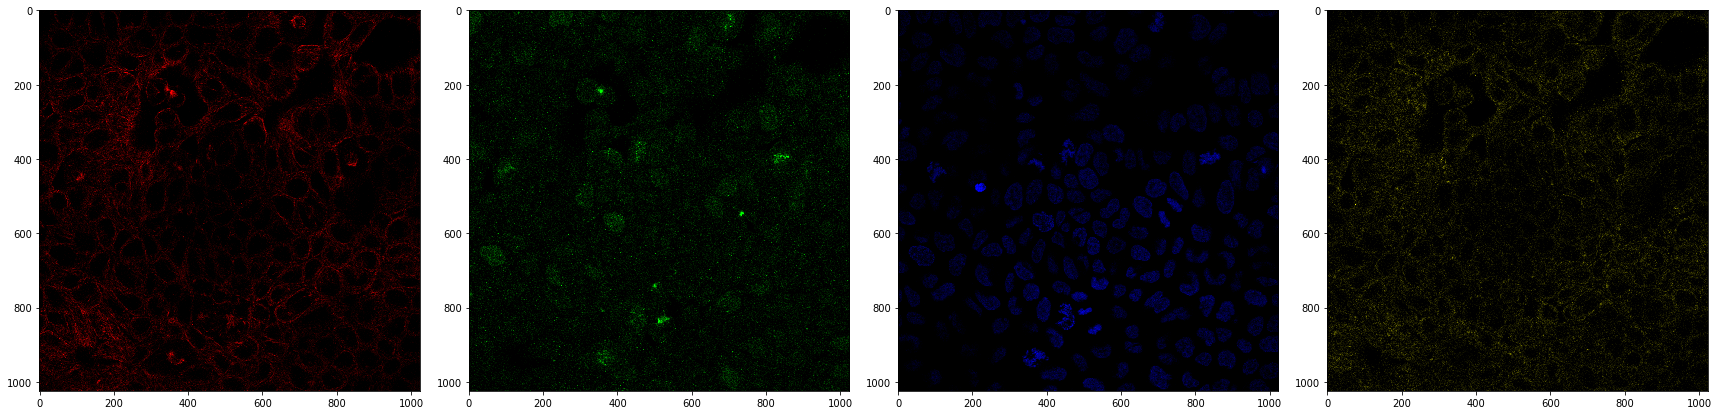

In [145]:
plot_rgby(open_numpy(X[0]).px)